Keerthan Kumar C

In [1]:
!pip install tsplib95

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.35.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
scikit-image 0.25.1 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
nx-cugraph-cu12 24.12.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cub

## Hill Climbing Implementation for TSP

In [2]:
import tsplib95
import numpy as np

def get_coordinates(problem):
    """Extract coordinates from the TSP problem."""

    return {node: problem.node_coords[node] for node in problem.get_nodes()}

def euclidean_distance(start_coords, end_coords):
    """Compute the Euclidean distance between two points."""
    return np.sqrt((start_coords[0] - end_coords[0]) ** 2 + (start_coords[1] - end_coords[1]) ** 2)

def compute_distance_matrix(problem):
    """Compute the full distance matrix for the problem."""

    coordinates = get_coordinates(problem)

    n = len(coordinates)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            start = list(coordinates.keys())[i]
            end = list(coordinates.keys())[j]
            dist = euclidean_distance(coordinates[start], coordinates[end])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # Since the distance is symmetric

    return distance_matrix


problem = tsplib95.load('./rd100.tsp')


distance_matrix = compute_distance_matrix(problem)


print(distance_matrix)


[[   0.         1134.34650195  421.26654102 ...  766.44389621
   543.59588049  820.04715234]
 [1134.34650195    0.          807.31092407 ...  414.90794398
   643.11343403  414.45806164]
 [ 421.26654102  807.31092407    0.         ...  397.46091036
   164.23692755  621.7397887 ]
 ...
 [ 766.44389621  414.90794398  397.46091036 ...    0.
   235.7065088   386.12785427]
 [ 543.59588049  643.11343403  164.23692755 ...  235.7065088
     0.          485.04202491]
 [ 820.04715234  414.45806164  621.7397887  ...  386.12785427
   485.04202491    0.        ]]


In [3]:
import random
import numpy as np

# Function to calculate the total distance of a path (sum of distances between consecutive cities)
def total_distance(path, distance_matrix):
    return sum(distance_matrix[path[i], path[i + 1]] for i in range(len(path) - 1)) + distance_matrix[path[-1], path[0]]

# Function to get neighbors (all possible neighboring solutions)
def get_neighbors(path):
    neighbors = []
    for i in range(len(path)):
        for j in range(i + 1, len(path)):
            # Swap two cities to create a neighbor
            new_path = path[:]
            new_path[i], new_path[j] = new_path[j], new_path[i]
            neighbors.append(new_path)
    return neighbors

'''
basic idea is take a randomly inital path then,find all its neighoburs just swapping the two cities then in simple first best path than current taken,in steepest all is examined
and best is taken, in stochastic randomly it is taken and if its distance is less than current then it is taken and if not then it is discarded(done till max attempt).
'''
# Simple Hill Climbing
def simple_hill_climbing(initial_path, distance_matrix):
    current_path = initial_path
    current_distance = total_distance(current_path, distance_matrix)

    while True:
        neighbors = get_neighbors(current_path)
        next_path = None
        next_distance = current_distance

        for neighbor in neighbors:
            neighbor_distance = total_distance(neighbor, distance_matrix)
            if neighbor_distance < next_distance:
                next_path = neighbor
                next_distance = neighbor_distance
                break # Stop after finding the first improvement


        if next_path is None:  # No improvement, so stop
            break

        current_path = next_path
        current_distance = next_distance

    return current_path, current_distance

# Stochastic Hill Climbing
def stochastic_hill_climbing(initial_path, distance_matrix, max_attempts=100):
    current_path = initial_path
    current_distance = total_distance(current_path, distance_matrix)

    attempts = 0  # Track attempts without improvement

    while attempts < max_attempts:
        neighbors = get_neighbors(current_path)
        next_path = random.choice(neighbors)  # Randomly choose a neighbor
        next_distance = total_distance(next_path, distance_matrix)

        if next_distance < current_distance:
            current_path = next_path
            current_distance = next_distance
            attempts = 0  # Reset attempts if improvement is found
        else:
            attempts += 1  # Count non-improving steps

    return current_path, current_distance


# Steepest Ascent Hill Climbing
def steepest_ascent_hill_climbing(initial_path, distance_matrix):
    current_path = initial_path
    current_distance = total_distance(current_path, distance_matrix)

    while True:
        neighbors = get_neighbors(current_path)
        best_path = current_path
        best_distance = current_distance

        for neighbor in neighbors:
            neighbor_distance = total_distance(neighbor, distance_matrix)
            if neighbor_distance < best_distance:
                best_path = neighbor
                best_distance = neighbor_distance

        if best_path == current_path:  # No better neighbor found
            break

        current_path = best_path
        current_distance = best_distance

    return current_path, current_distance


'''
in simulated annealing it is similar to stochastic where random neighbour is taken and if its distance is less than current i.e the delta is negative(new-current) then we accept else
(meaning worse solution)but still we accept with a probability P=e^−ΔE/T where T is temp which will be high at start and go on decreasing. this helps in avoiding local minima.
'''

def simulated_annealing(initial_path, distance_matrix, initial_temp=1000, cooling_rate=0.995, min_temp=1):
    current_path = initial_path
    current_distance = total_distance(current_path, distance_matrix)
    temperature = initial_temp

    while temperature > min_temp:
        # Generate a random neighbor
        neighbors = get_neighbors(current_path)
        next_path = random.choice(neighbors)
        next_distance = total_distance(next_path, distance_matrix)

        # Calculate energy difference
        delta_E = next_distance - current_distance

        # Accept new path if it's better OR with probability e^(-ΔE / T)
        if delta_E < 0 or random.random() < np.exp(-delta_E / temperature):
            current_path = next_path
            current_distance = next_distance

        # Cool down the temperature
        temperature *= cooling_rate

    return current_path, current_distance


# Example usage
def run_hill_climbing(distance_matrix):
    # Generate a random initial path
    num_cities = len(distance_matrix)
    initial_path = list(range(num_cities))
    random.shuffle(initial_path)

    print(f"Initial Random Path: {initial_path}")

    # Simple Hill Climbing
    best_path, best_distance = simple_hill_climbing(initial_path, distance_matrix)
    print(f"Simple Hill Climbing: Best Path: {best_path}, Distance: {best_distance}")

    # Stochastic Hill Climbing
    best_path, best_distance = stochastic_hill_climbing(initial_path, distance_matrix)
    print(f"Stochastic Hill Climbing: Best Path: {best_path}, Distance: {best_distance}")

    # Steepest Ascent Hill Climbing
    best_path, best_distance = steepest_ascent_hill_climbing(initial_path, distance_matrix)
    print(f"Steepest Ascent Hill Climbing: Best Path: {best_path}, Distance: {best_distance}")

    # Simulated Annealing
    best_path, best_distance = simulated_annealing(initial_path, distance_matrix)
    print(f"Simulated Annealing: Best Path: {best_path}, Distance: {best_distance}")

# Run the hill-climbing algorithms
run_hill_climbing(distance_matrix)



Initial Random Path: [50, 24, 52, 48, 30, 96, 82, 19, 10, 75, 69, 45, 62, 64, 99, 71, 67, 7, 38, 13, 34, 60, 2, 93, 22, 35, 79, 85, 25, 56, 65, 9, 33, 87, 97, 1, 31, 40, 59, 23, 47, 57, 74, 20, 37, 68, 28, 29, 14, 77, 55, 98, 72, 18, 91, 78, 26, 32, 17, 58, 81, 6, 16, 3, 63, 54, 43, 39, 27, 80, 0, 36, 21, 51, 4, 89, 84, 94, 5, 49, 12, 86, 44, 11, 53, 61, 15, 46, 76, 73, 90, 88, 83, 66, 8, 42, 41, 95, 70, 92]
Simple Hill Climbing: Best Path: [73, 25, 8, 16, 37, 69, 71, 17, 70, 67, 82, 47, 29, 23, 24, 42, 38, 34, 22, 1, 88, 87, 65, 97, 93, 56, 4, 60, 10, 51, 99, 43, 44, 30, 83, 28, 95, 54, 39, 41, 79, 64, 50, 89, 90, 5, 36, 18, 53, 72, 49, 45, 55, 91, 19, 77, 81, 84, 11, 13, 20, 74, 48, 66, 80, 21, 40, 6, 33, 15, 94, 58, 92, 76, 2, 85, 96, 62, 14, 86, 61, 0, 59, 7, 68, 98, 78, 9, 32, 26, 27, 57, 75, 31, 3, 12, 63, 35, 46, 52], Distance: 14703.441362406895
Stochastic Hill Climbing: Best Path: [41, 6, 58, 92, 93, 2, 52, 65, 57, 45, 9, 40, 23, 4, 12, 78, 98, 10, 60, 51, 44, 83, 87, 15, 46, 

### Implementing for the Job Scheduling

#### Understanding

### **Job Scheduling Using Hill Climbing Algorithms**  
This problem involves efficiently assigning jobs to machines such that the **total processing time is minimized**. We will implement **Simple Hill Climbing, Stochastic Hill Climbing, and Steepest Ascent Hill Climbing** to optimize job scheduling.

---

## **1. Problem Definition**  
We have:  
- A **set of jobs** with different processing times.  
- A **set of machines** to which jobs must be assigned.  
- Our objective is to **minimize the maximum processing time** across all machines (i.e., make the workload as balanced as possible).  

### **Constraints**  
- Each job must be assigned to exactly one machine.  
- The total processing time of a machine is the sum of the jobs assigned to it.  
- The goal is to minimize the processing time of the most loaded machine (makespan).  

---

## **2. Python Implementation**  
The implementation involves:  
✅ **Generating random job schedules** (initial solution).  
✅ **Defining a heuristic function** to evaluate schedules.  
✅ **Implementing the three Hill Climbing algorithms**:
   - **Simple Hill Climbing** (First improvement)  
   - **Stochastic Hill Climbing** (Random moves)  
   - **Steepest Ascent Hill Climbing** (Best improvement)  
✅ **Comparing performance** for different job sizes and machine counts.  

---

## **3. Heuristic Function**  
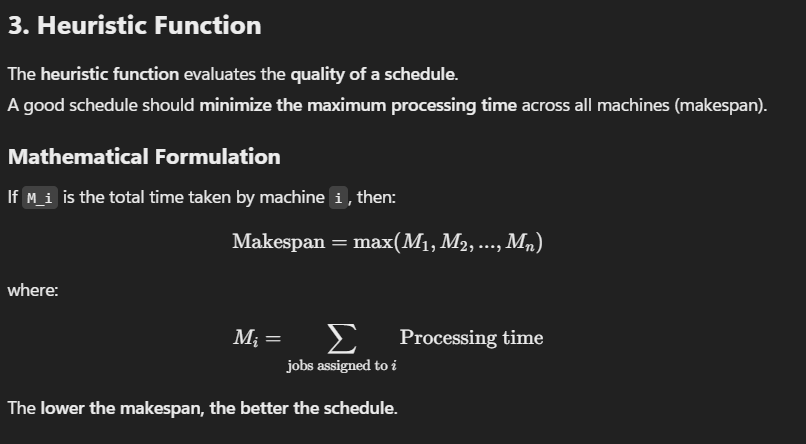

## **4. Hill Climbing Algorithms for Job Scheduling**

### **(i) Simple Hill Climbing**  
- **Steps**:
  1. Start with a **random schedule**.
  2. Generate **neighboring schedules** by **moving a job from one machine to another**.
  3. Pick the **first neighbor** that improves the makespan.
  4. Repeat until no better neighbor is found.  

🔹 **Limitation:** Might stop early at a local minimum.  

---

### **(ii) Stochastic Hill Climbing**  
- **Steps**:
  1. Start with a **random schedule**.
  2. **Randomly select** a neighbor (instead of checking all).
  3. If the neighbor is **better**, accept it.
  4. Stop after a fixed number of attempts if no improvement.  

🔹 **Advantage:** Can escape local minima.  
🔹 **Limitation:** May not always find the best solution.  

---

### **(iii) Steepest Ascent Hill Climbing**  
- **Steps**:
  1. Start with a **random schedule**.
  2. **Check all possible neighbors** and pick the **best one**.
  3. Repeat until no better solution exists.  

🔹 **Advantage:** Finds a much better local optimum.  
🔹 **Limitation:** **Computationally expensive** due to checking all neighbors.  



In [4]:
import random
import time
import numpy as np

# Function to calculate makespan (maximum load on any machine)
def calculate_makespan(schedule, num_machines):
    machine_loads = [0] * num_machines  # Initialize loads for each machine
    for machine, jobs in enumerate(schedule):
        machine_loads[machine] = sum(jobs)  # Sum up job times for each machine
    return max(machine_loads)  # Return the maximum load (makespan)

# Function to generate an initial random schedule
def generate_initial_schedule(jobs, num_machines):
    schedule = [[] for _ in range(num_machines)]  # Empty schedule for each machine
    for job in jobs:
        random.choice(schedule).append(job)  # Assign jobs randomly to machines
    return schedule

# Function to generate neighbors by moving a job from one machine to another
def get_neighbors(schedule):
    neighbors = []
    for i in range(len(schedule)):
        for j in range(len(schedule[i])):
            for k in range(len(schedule)):
                if i != k:  # Move job from machine i to machine k
                    new_schedule = [list(machine) for machine in schedule]
                    job = new_schedule[i].pop(j)
                    new_schedule[k].append(job)
                    neighbors.append(new_schedule)
    return neighbors

# Simple Hill Climbing
def simple_hill_climbing(jobs, num_machines):
    current_schedule = generate_initial_schedule(jobs, num_machines)
    current_makespan = calculate_makespan(current_schedule, num_machines)

    while True:
        neighbors = get_neighbors(current_schedule)
        found_better = False

        for neighbor in neighbors:
            neighbor_makespan = calculate_makespan(neighbor, num_machines)
            if neighbor_makespan < current_makespan:
                current_schedule = neighbor
                current_makespan = neighbor_makespan
                found_better = True
                break  # First improvement found, move to it

        if not found_better:
            break  # No better neighbor found, stop

    return current_schedule, current_makespan

# Stochastic Hill Climbing
def stochastic_hill_climbing(jobs, num_machines, max_attempts=100):
    current_schedule = generate_initial_schedule(jobs, num_machines)
    current_makespan = calculate_makespan(current_schedule, num_machines)

    attempts = 0
    while attempts < max_attempts:
        neighbors = get_neighbors(current_schedule)
        next_schedule = random.choice(neighbors)  # Randomly pick a neighbor
        next_makespan = calculate_makespan(next_schedule, num_machines)

        if next_makespan < current_makespan:
            current_schedule = next_schedule
            current_makespan = next_makespan
            attempts = 0  # Reset attempts
        else:
            attempts += 1

    return current_schedule, current_makespan

# Steepest Ascent Hill Climbing
def steepest_ascent_hill_climbing(jobs, num_machines):
    current_schedule = generate_initial_schedule(jobs, num_machines)
    current_makespan = calculate_makespan(current_schedule, num_machines)

    while True:
        neighbors = get_neighbors(current_schedule)
        best_schedule = current_schedule
        best_makespan = current_makespan

        for neighbor in neighbors:
            neighbor_makespan = calculate_makespan(neighbor, num_machines)
            if neighbor_makespan < best_makespan:
                best_schedule = neighbor
                best_makespan = neighbor_makespan

        if best_schedule == current_schedule:  # No improvement found
            break

        current_schedule = best_schedule
        current_makespan = best_makespan

    return current_schedule, current_makespan

# Function to run all algorithms and compare performance
def run_job_scheduling(jobs, num_machines):
    print(f"Jobs: {jobs}")
    print(f"Number of machines: {num_machines}\n")

    start = time.time()
    best_schedule, best_makespan = simple_hill_climbing(jobs, num_machines)
    print(f"Simple Hill Climbing: Makespan = {best_makespan}, Time = {time.time() - start:.4f} sec")

    start = time.time()
    best_schedule, best_makespan = stochastic_hill_climbing(jobs, num_machines)
    print(f"Stochastic Hill Climbing: Makespan = {best_makespan}, Time = {time.time() - start:.4f} sec")

    start = time.time()
    best_schedule, best_makespan = steepest_ascent_hill_climbing(jobs, num_machines)
    print(f"Steepest Ascent Hill Climbing: Makespan = {best_makespan}, Time = {time.time() - start:.4f} sec")

# Example Run
jobs = [random.randint(1, 100) for _ in range(10)]  # Random job times
num_machines = 3  # Number of machines
run_job_scheduling(jobs, num_machines)


Jobs: [4, 20, 39, 80, 97, 68, 3, 87, 98, 35]
Number of machines: 3

Simple Hill Climbing: Makespan = 195, Time = 0.0003 sec
Stochastic Hill Climbing: Makespan = 195, Time = 0.0018 sec
Steepest Ascent Hill Climbing: Makespan = 195, Time = 0.0002 sec



Here’s the breakdown of the **Job Scheduling using Hill Climbing** approach:  

1. **Initial Solution**:  
   - Distribute jobs randomly across machines.  
   - Each machine has a list of jobs assigned to it.  

2. **Heuristic Function (Evaluation)**:  
   - Compute the **makespan**, which is the maximum processing time among all machines.  
   - This helps in determining how balanced the job allocation is.  

3. **Generating Neighbors**:  
   - Modify the job assignments by moving a job from one machine to another.  
   - Generate a set of possible configurations (neighbors).  

4. **Applying Hill Climbing Variants**:  
   - **Simple Hill Climbing**: Pick the first neighbor with a lower makespan.  
   - **Steepest Ascent Hill Climbing**: Evaluate all neighbors and select the best one.  
   - **Stochastic Hill Climbing**: Pick a random neighbor and accept it if it improves makespan.  

5. **Stopping Condition**:  
   - No better neighbor exists.  
   - Maximum iterations reached.  


### Experimentation for different jobs and machines sizes

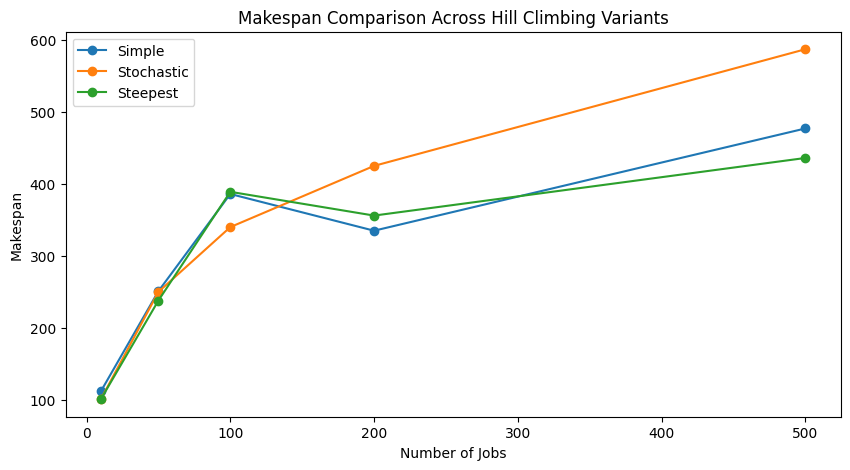

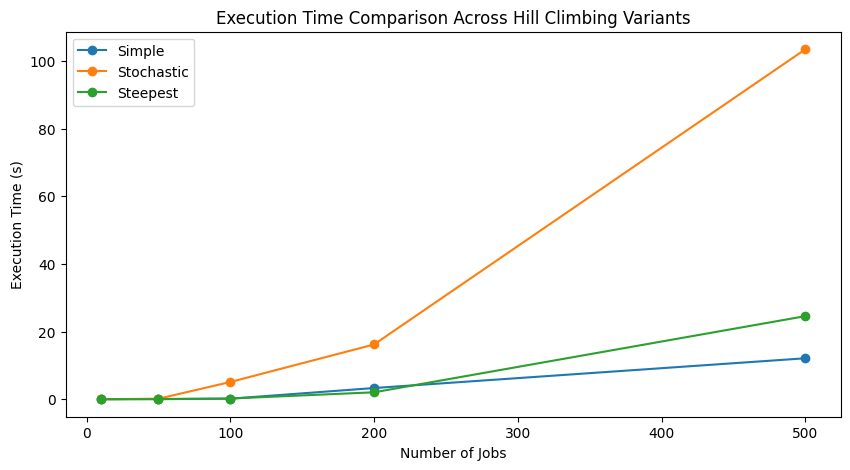

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Generate random jobs and assign them to machines randomly
def generate_initial_schedule(num_jobs, num_machines):
    jobs = np.random.randint(1, 100, size=num_jobs)  # Job processing times
    schedule = [[] for _ in range(num_machines)]
    for job in jobs:
        random.choice(schedule).append(job)  # Assign job to a random machine
    return schedule

# Compute makespan (heuristic function)
def makespan(schedule):
    return max(sum(machine) for machine in schedule)

# Get neighbors by moving a job from one machine to another
def get_neighbors(schedule):
    neighbors = []
    for i in range(len(schedule)):
        for j in range(len(schedule)):
            if i != j and schedule[i]:  # Ensure valid move
                new_schedule = [machine[:] for machine in schedule]
                job = random.choice(new_schedule[i])
                new_schedule[i].remove(job)
                new_schedule[j].append(job)
                neighbors.append(new_schedule)
    return neighbors

# Simple Hill Climbing
def simple_hill_climbing(initial_schedule):
    current_schedule = initial_schedule
    current_makespan = makespan(current_schedule)

    while True:
        neighbors = get_neighbors(current_schedule)
        found_better = False

        for neighbor in neighbors:
            neighbor_makespan = makespan(neighbor)
            if neighbor_makespan < current_makespan:
                current_schedule = neighbor
                current_makespan = neighbor_makespan
                found_better = True
                break  # First improvement found

        if not found_better:
            break  # Stop if no improvement

    return current_schedule, current_makespan

# Stochastic Hill Climbing
def stochastic_hill_climbing(initial_schedule, max_attempts=100):
    current_schedule = initial_schedule
    current_makespan = makespan(current_schedule)
    attempts = 0

    while attempts < max_attempts:
        neighbors = get_neighbors(current_schedule)
        if not neighbors:
            break

        next_schedule = random.choice(neighbors)  # Random choice
        next_makespan = makespan(next_schedule)

        if next_makespan < current_makespan:
            current_schedule = next_schedule
            current_makespan = next_makespan
            attempts = 0  # Reset attempts if improved
        else:
            attempts += 1  # Increment non-improving attempts

    return current_schedule, current_makespan

# Steepest Ascent Hill Climbing
def steepest_ascent_hill_climbing(initial_schedule):
    current_schedule = initial_schedule
    current_makespan = makespan(current_schedule)

    while True:
        neighbors = get_neighbors(current_schedule)
        best_schedule = current_schedule
        best_makespan = current_makespan

        for neighbor in neighbors:
            neighbor_makespan = makespan(neighbor)
            if neighbor_makespan < best_makespan:
                best_schedule = neighbor
                best_makespan = neighbor_makespan

        if best_schedule == current_schedule:
            break  # Stop if no improvement

        current_schedule = best_schedule
        current_makespan = best_makespan

    return current_schedule, current_makespan

# Run experiments and generate graphs
def run_experiments(job_sizes, machine_sizes):
    results = {"Simple": [], "Stochastic": [], "Steepest": []}
    execution_times = {"Simple": [], "Stochastic": [], "Steepest": []}

    for num_jobs, num_machines in zip(job_sizes, machine_sizes):
        initial_schedule = generate_initial_schedule(num_jobs, num_machines)

        start = time.time()
        _, best_simple = simple_hill_climbing(initial_schedule)
        execution_times["Simple"].append(time.time() - start)
        results["Simple"].append(best_simple)

        start = time.time()
        _, best_stochastic = stochastic_hill_climbing(initial_schedule)
        execution_times["Stochastic"].append(time.time() - start)
        results["Stochastic"].append(best_stochastic)

        start = time.time()
        _, best_steepest = steepest_ascent_hill_climbing(initial_schedule)
        execution_times["Steepest"].append(time.time() - start)
        results["Steepest"].append(best_steepest)

    # Plot Makespan
    plt.figure(figsize=(10, 5))
    for method in results:
        plt.plot(job_sizes, results[method], marker='o', label=method)
    plt.xlabel("Number of Jobs")
    plt.ylabel("Makespan")
    plt.title("Makespan Comparison Across Hill Climbing Variants")
    plt.legend()
    plt.show()

    # Plot Execution Time
    plt.figure(figsize=(10, 5))
    for method in execution_times:
        plt.plot(job_sizes, execution_times[method], marker='o', label=method)
    plt.xlabel("Number of Jobs")
    plt.ylabel("Execution Time (s)")
    plt.title("Execution Time Comparison Across Hill Climbing Variants")
    plt.legend()
    plt.show()

# Define problem sizes
job_sizes = [10, 50, 100, 200, 500]
machine_sizes = [5, 10, 20, 50, 100]

# Run experiments
run_experiments(job_sizes, machine_sizes)

### Implementation for N-Queens

## Understanding the problem

### **Problem Representation**
- The **board state** is represented as an array where the index represents the column, and the value at that index represents the row of the queen in that column.  
  - Example for **N = 4**: `[1, 3, 0, 2]` means:
    - Queen in column 0 is at row 1
    - Queen in column 1 is at row 3
    - Queen in column 2 is at row 0
    - Queen in column 3 is at row 2

---

### **Heuristic Function**
- The heuristic function calculates the **number of attacking pairs**:
  - Two queens are **attacking** if they are:
    - In the same row
    - In the same diagonal (difference of row and column is the same)
- **Goal:** Minimize the heuristic to **0**, meaning no queens are attacking each other.

---

### **Generating Neighbors**
- **Neighbors** are generated by **moving a single queen** to a different row in the same column.
- For **each column**, we generate all possible row positions and calculate the heuristic.
- Based on the Hill Climbing variant, we decide how to select the next state.

---

### **Hill Climbing Variants**
1. **Simple Hill Climbing**
   - Moves to the first better (lower heuristic) neighbor found.
   - Stops at local optima if no better moves exist.

2. **Stochastic Hill Climbing**
   - Chooses a random neighbor from the ones that improve the heuristic.
   - Helps escape some local optima.

3. **Steepest Ascent Hill Climbing**
   - Evaluates all neighbors and picks the best improvement.
   - Provides a better chance of finding a global minimum.

---

### **Algorithm Steps**
1. **Initialize board randomly**
2. **Compute heuristic (number of attacking pairs)**
3. **Generate neighbors and apply the hill climbing rule (Simple, Stochastic, Steepest)**
4. **If local optima is reached, restart from a new random state (with a limit on restarts)**
5. **Track the number of iterations, execution time, and success rate.**
6. **Compare performance across different values of N (4, 8, 16, 32, 64).**

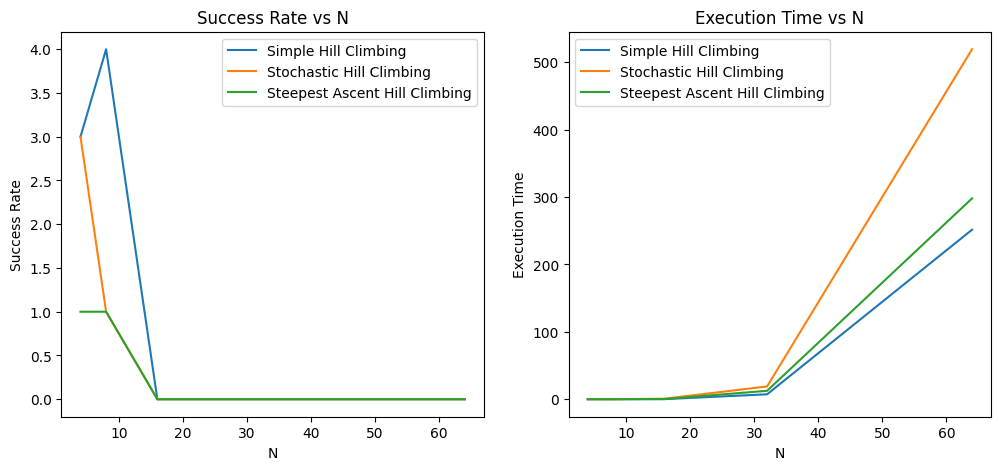

In [6]:
import random
import time
import matplotlib.pyplot as plt

# Heuristic function: Counts the number of attacking pairs
def heuristic(board):
    n = len(board)
    attacks = 0
    for i in range(n):
        for j in range(i + 1, n):
            if board[i] == board[j] or abs(board[i] - board[j]) == abs(i - j):
                attacks += 1
    return attacks

# Generate neighbors by moving a queen in one column to a different row
def get_neighbors(board):
    n = len(board)
    neighbors = []
    for col in range(n):
        for row in range(n):
            if board[col] != row:
                new_board = board[:]
                new_board[col] = row
                neighbors.append(new_board)
    return neighbors

# Simple Hill Climbing Algorithm
def simple_hill_climbing(board):
    current_board = board
    current_heuristic = heuristic(board)
    while True:
        neighbors = get_neighbors(current_board)
        next_board = None
        for neighbor in neighbors:
            if heuristic(neighbor) < current_heuristic:
                next_board = neighbor
                break  # Stop at first improvement
        if next_board is None:
            break
        current_board = next_board
        current_heuristic = heuristic(current_board)
    return current_board, current_heuristic

# Stochastic Hill Climbing Algorithm
def stochastic_hill_climbing(board):
    current_board = board
    current_heuristic = heuristic(board)
    while True:
        neighbors = get_neighbors(current_board)
        better_neighbors = [neighbor for neighbor in neighbors if heuristic(neighbor) < current_heuristic]
        if not better_neighbors:
            break
        current_board = random.choice(better_neighbors)
        current_heuristic = heuristic(current_board)
    return current_board, current_heuristic

# Steepest Ascent Hill Climbing Algorithm
def steepest_ascent_hill_climbing(board):
    current_board = board
    current_heuristic = heuristic(board)
    while True:
        neighbors = get_neighbors(current_board)
        best_neighbor = min(neighbors, key=heuristic)
        best_heuristic = heuristic(best_neighbor)
        if best_heuristic >= current_heuristic:
            break
        current_board = best_neighbor
        current_heuristic = best_heuristic
    return current_board, current_heuristic

# Runs experiments for different values of N and plots results
def run_experiment():
    ns = [4, 8, 16, 32, 64]
    algorithms = {
        "Simple Hill Climbing": simple_hill_climbing,
        "Stochastic Hill Climbing": stochastic_hill_climbing,
        "Steepest Ascent Hill Climbing": steepest_ascent_hill_climbing,
    }
    results = {alg: [] for alg in algorithms}

    for n in ns:
        for alg_name, alg_func in algorithms.items():
            start_time = time.time()
            success_count = 0
            iterations = 0
            for _ in range(10):  # Run multiple times to get success rate
                initial_board = [random.randint(0, n - 1) for _ in range(n)]
                final_board, final_heuristic = alg_func(initial_board)
                if final_heuristic == 0:
                    success_count += 1
                iterations += 1
            execution_time = time.time() - start_time
            results[alg_name].append((success_count, execution_time, iterations))

    # Plot results
    plt.figure(figsize=(12, 5))
    for metric_idx, metric_name in enumerate(["Success Rate", "Execution Time"]):
        plt.subplot(1, 2, metric_idx + 1)
        for alg_name in algorithms:
            plt.plot(ns, [results[alg_name][i][metric_idx] for i in range(len(ns))], label=alg_name)
        plt.xlabel("N")
        plt.ylabel(metric_name)
        plt.title(f"{metric_name} vs N")
        plt.legend()
    plt.show()

run_experiment()


In [ ]:
'''
Basic explanation among all is this:
So all of them is basically simple where we first see the inital solution and define the heuristic for that problem(like distance,makespan,attacking pairs sum)
then we generate all negihbours of current and iterate and take the best one based on different hill climbing strategy(basic is this)
'''